# Tarea 2

Jairo Saul Diaz Soto

Dr. Jean-Bernanrd Hayet

Vision Computacional I

2024 / 02 / 1502 / 11

---
## Ejercicio 1: Calibracion de Camara

In [12]:
import cv2 as cv
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
##Cirterios de Paro
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

##Preparando los puntos objetivo
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)

## Arreglos para almacenar los puntos objetivo y los puntos de todas las imagenes
objpoints = [] ## Puntos 3d en el espacio del mundo real
imgpoints = [] ## Puntos 2d en el plano de la imagen

imgs = glob.glob('*.jpg')
images = []


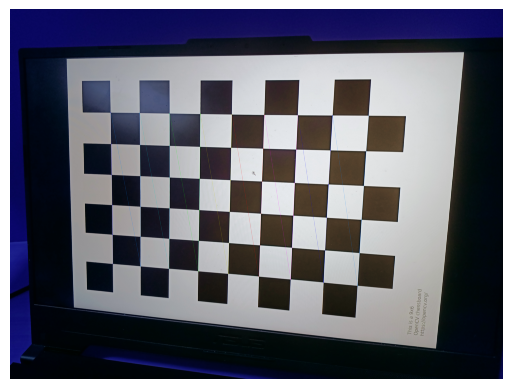

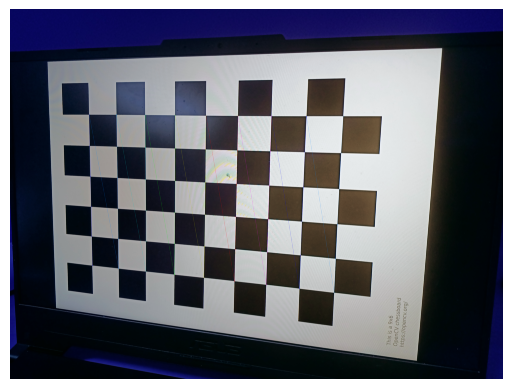

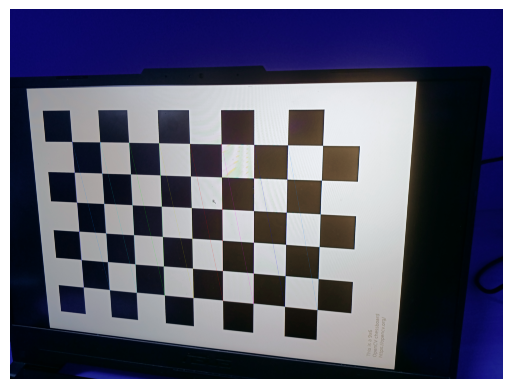

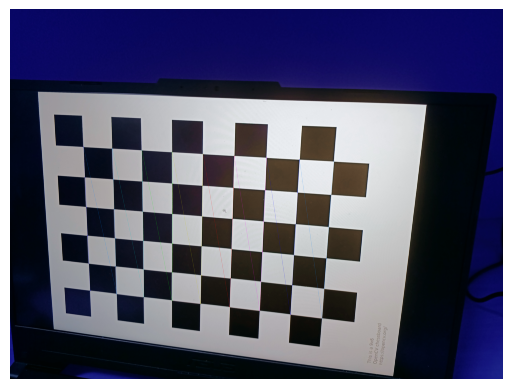

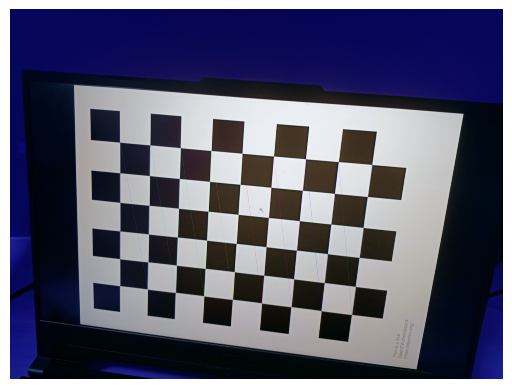

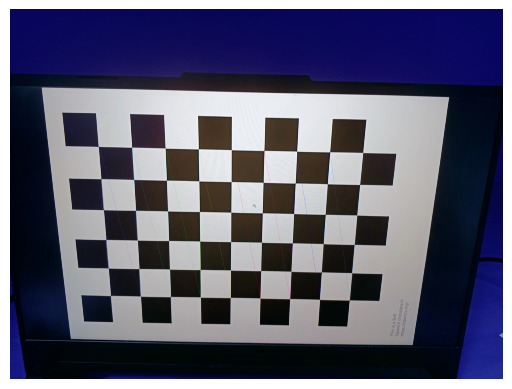

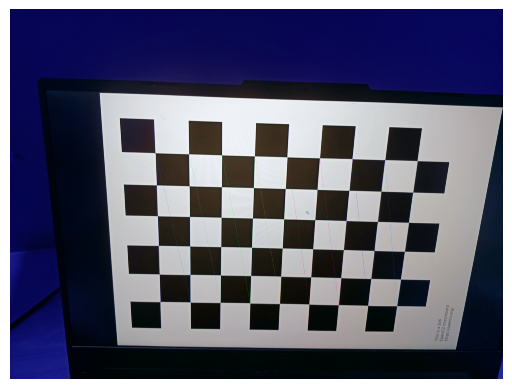

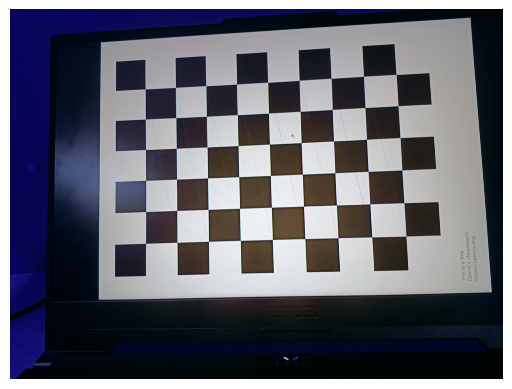

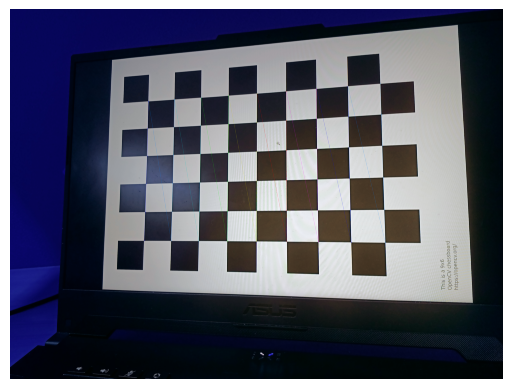

In [14]:
for fname in imgs:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    ## Encontrando las esquinas del tablero de ajedrez
    ret, corners, = cv.findChessboardCorners(gray, (6,9), None)

    ## Si las encuentra, agrega los puntos objetivo, los puntos de la imagen si los encuentra (despues de encontrarlos)
    if ret is True:
        images.append(fname)
        objpoints.append(objp)

        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        ##Despliega y dibuja las esquinas
        cv.drawChessboardCorners(img, (6,9), corners2, ret)
        plt.imshow(img)
        plt.axis("off")
        plt.show()

In [15]:
##Calibracion
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [16]:
## Eliminando la distorsion
img = cv.imread('IMG20240213131552.jpg')
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1 , (w,h))

Utilizando cv.undistort()

In [17]:
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

#crop de image
x, y, w, h =  roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('calibresult.png', dst)

True

Utilizando remapping

TypeError: Image data of dtype <U15 cannot be converted to float

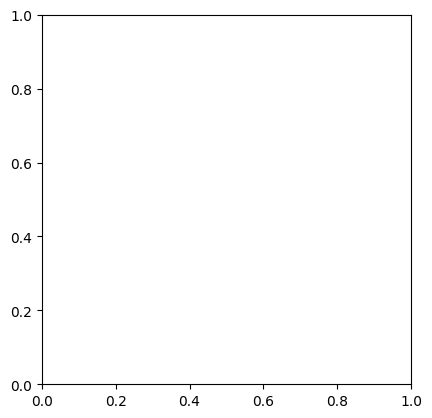

In [22]:
plt.imshow('calibresult.png')

In [18]:
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dts = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

#crop de image
x, y, w, h =  roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('calibresultrmp.png', dst)

True

In [ ]:
plt.imshow('calibresultrmp.png.png')

Error de reproyeccion

In [19]:
mean_erro = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2) / len(imgpoints2)
    mean_erro += error

print('Total error: {}'.format(mean_erro/len(objpoints)))

Total error: 0.27605324466613346


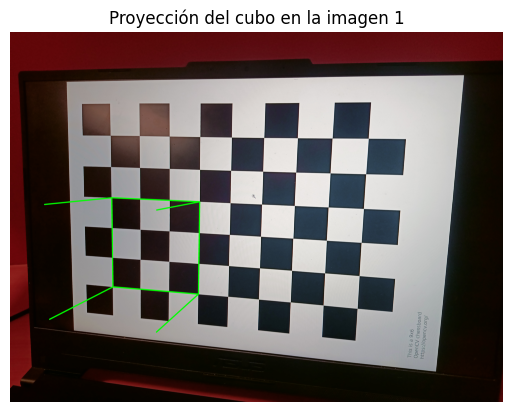

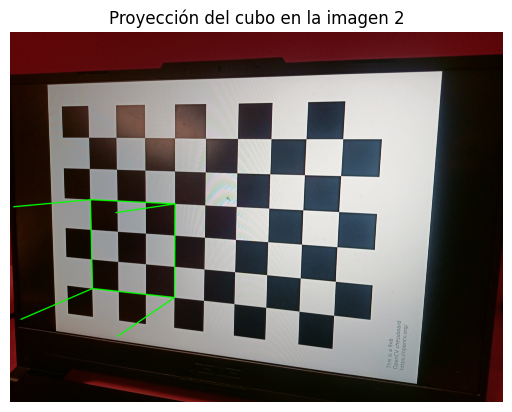

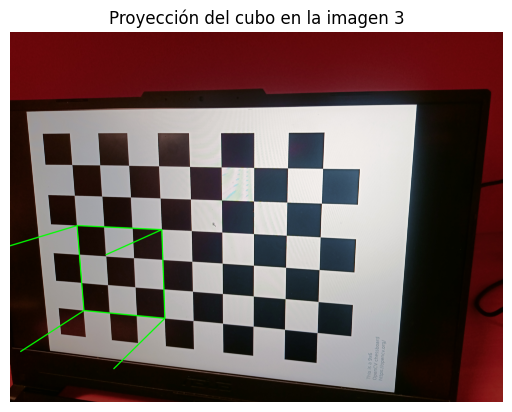

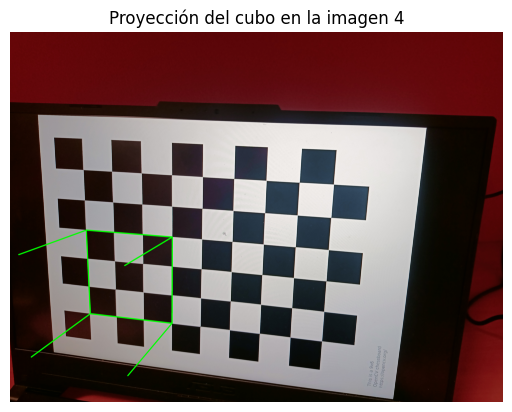

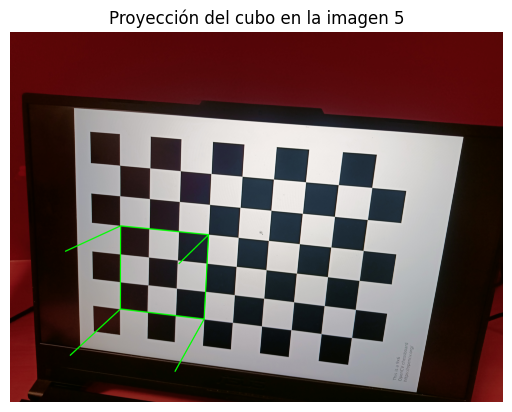

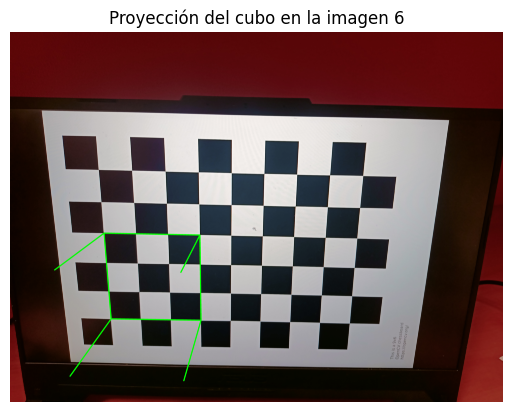

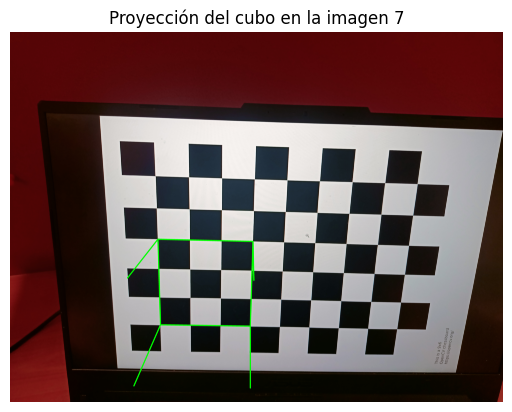

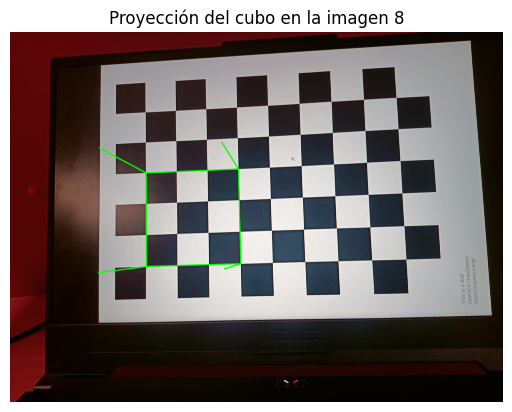

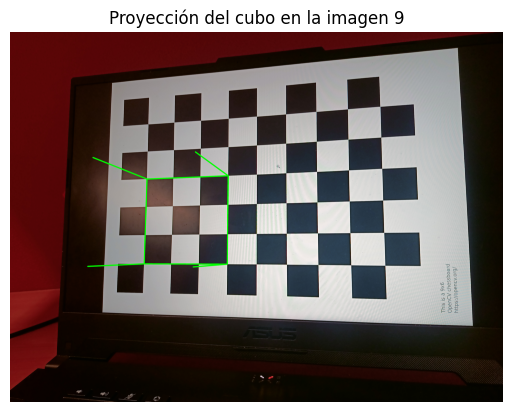

In [20]:
from mpl_toolkits.mplot3d import Axes3D

# Definir la forma 3D (puntos del cubo)
cube_size = 3  # Tamaño del cubo
cube_points = np.array([[0, 0, 0],
                        [cube_size, 0, 0],
                        [cube_size, cube_size, 0],
                        [0, cube_size, 0],
                        [0, 0, -cube_size],
                        [cube_size, 0, -cube_size],
                        [cube_size, cube_size, -cube_size],
                        [0, cube_size, -cube_size]], dtype=np.float32)

# Puntos 2D proyectados en todas las imágenes
projected_points_list = []

# Bucle para proyectar el cubo en cada imagen
for i, fname in enumerate(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Proyectar puntos 3D a puntos 2D
    rvec, tvec = rvecs[i], tvecs[i]
    projected_points, _ = cv.projectPoints(cube_points, rvec, tvec, mtx, dist)

    # Dibujar líneas más gruesas entre los puntos proyectados para formar el cubo
    for j in range(4):
        point1 = tuple(map(int, projected_points[j].ravel()))
        point2 = tuple(map(int, projected_points[(j + 1) % 4].ravel()))
        cv.line(img, point1, point2, (0, 255, 0), 20)  # Grosor 3

        cv.line(img, point1, tuple(map(int, projected_points[j + 4].ravel())), (0, 255, 0), 20)  # Grosor 3
        cv.line(img, point2, tuple(map(int, projected_points[(j + 1) % 4 + 4].ravel())), (0, 255, 0), 20)  # Grosor 3


    # Muestra la imagen con el cubo proyectado
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(f'Proyección del cubo en la imagen {i + 1}')
    plt.axis('off')
    plt.show()

## Ejercicio 2: Descomposicion de la matriz de proyeccion

In [21]:
def Ab_decomp(K, R, t, theta = np.pi/2):
    A = np.zeros((3,3))
    b = np.array()

    A[0,:] = (K[0,0] * R[:,0]) - (K[0,0] * R[:,1] * np.cos(theta) / np.sin(theta)) + (K[0,2] * R[:,2])
    A[1,:] = (K[1,1] * R[:,1] / NP.sin(theta)) + (K[1,2] * R[:,2])
    A[2,:] = R[:,2]

    b[0] = (K[0,0] * t[0]) - (K[0,0] * t[1] * np.cos(theta) / np.sin(theta)) + (K[0,2] * t[2])
    b[1] = (K[1,1] * t[1] / NP.sin(theta)) + (K[1,2] * t[2])
    b[2] = t[2]

    return A, b

## Ejercicio 3: Ecuacion del rayo 3D

Bien, entonces se tiene lo siguiente si $K$ es la matriz de parametros intrinsecos de una camara definida como
$$
K = \left[ \begin{matrix}
                    f_x & 0 & c_x \\
                    0 & f_y & c_y \\
                    0 & 0 & 1
\end{matrix} \right]
$$

donde se tiene que $f_x, f_y$ son las distancias focales en sus respectivas direcciones ademas $c_x, c_y$ son las coordenadas del punto por donde pasa el eje optico.

A partir de aqui entonces, encontramos que la matriz inversa se define de la siguiente forma
$$
K^{-1} = \left[ \begin{matrix}
                    f_x^{-1} & 0 & -\frac{c_x}{f_x} \\
                    0 & f_y^{-1} & -\frac{c_y}{f_y} \\
                    0 & 0 & 1
\end{matrix} \right]
$$

Por lo cual, al aplicar esta transformacion a algun punto que nos parezca interesante en la imagen $(u, v)$, es posible obtener la informacion del haz de luz del mundo real que lo proyecta tal que

$$
\left ( \begin{matrix}
    x \\
    y \\
    z
\end{matrix} \right)
=
\left[ \begin{matrix}
                    f_x^{-1} & 0 & -\frac{c_x}{f_x} \\
                    0 & f_y^{-1} & -\frac{c_y}{f_y} \\
                    0 & 0 & 1
\end{matrix} \right]
\left ( \begin{matrix}
    u \\
    v \\
    1
\end{matrix} \right)
$$

De lo cual entonces se tiene el sistema de ecuaciones tal que:
$$
\begin{matrix}
    x = \frac{u - c_x}{f_x} \\
    y = \frac{v - c_y}{f_x} \\
    z = 1
\end{matrix}
$$

Obteniendo asi la ecuacion del rayo.

## Ejercicio 4
Partiendo del hecho de que se tiene una matriz de proyeccion tal que $P \propto K [R|t]$, adicionalmente de que se sabe que los puntos en el infinito sobre el plano se proponen como

$$
\left(\begin{matrix} u \\ v \\ 0 \end{matrix}\right)
$$

Con esto entonces tenemos que 

$$
K[R|t] \left( \begin{matrix} x \\ y \\ z \\ 1 \end{matrix}\right) = 
\left(\begin{matrix} u \\ v \\ 0 \end{matrix}\right)
$$

De esta forma entonces, desarrollando la operacion correspondiente a la matriz $K[R|t]$ por el punto tenemos que
$$
r_1 x + r_2  y + r_3  z + t = 0
$$

donde $r_i$ son las columnas de la matriz de rotacion.
